# create interactive debugging tool for data

In [18]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
from data_acquisition import NHLDataFetcher 
import pprint
import matplotlib.image as mpimg 
from typing import Union
from textwrap import dedent
import os

In [19]:
# define function and variable for plot nhl data
#season_list = [2015,2016,2017,2018,2019,2020,2021,2022,2023]
season_list = [2015]
game_type = ['regular', 'playoff']
nhl_data = NHLDataFetcher(base_url = "https://api-web.nhle.com/v1/gamecenter/{}/play-by-play") 


Label(value='Max Game ID: 1230')

interactive(children=(Dropdown(description='Season:', options=('2015', '2016', '2017', '2018', '2019', '2020',…

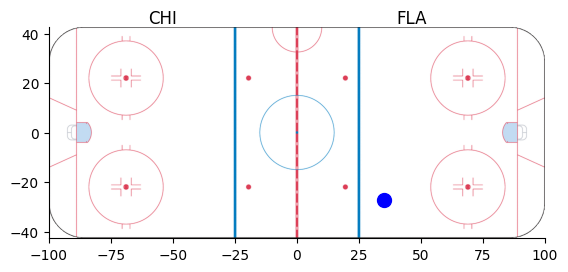

{'details': {'awaySOG': 10,
             'eventOwnerTeamId': 13,
             'goalieInNetId': 8474152,
             'homeSOG': 12,
             'shootingPlayerId': 8475755,
             'shotType': 'slap',
             'xCoord': 35,
             'yCoord': -27,
             'zoneCode': 'O'},
 'eventId': 266,
 'periodDescriptor': {'maxRegulationPeriods': 3,
                      'number': 2,
                      'periodType': 'REG'},
 'situationCode': '1551',
 'sortOrder': 268,
 'timeInPeriod': '05:59',
 'timeRemaining': '14:01',
 'typeCode': 506,
 'typeDescKey': 'shot-on-goal'}


In [21]:
class NHLDataViewer:
    def __init__(self):
          self.select_season = ''
          self.select_game_type = ''    
   

    def visualize_events(self,season, game_type, game_id):
        game_type_value = '03'
        if(game_type == 'regular'):
            game_type_value = '02'
        game_id =  f"game_{season}{game_type_value}{str(game_id).zfill(4)}"

        game_data = nhl_data.get_game_data_by_id(game_id)
        if( game_data != None):
            time_label = widgets.Label(value=game_data['startTimeUTC'])
            title_label = widgets.Label(value=f"Game ID: {game_data['id'] }; {game_data['homeTeam']['abbrev']}(home) VS {game_data['awayTeam']['abbrev']}(away)")
            display(time_label,title_label)

            #print(game_data)
            print(game_data['startTimeUTC'])
            print(f"Game ID: {game_data['id']}; {game_data['homeTeam']['abbrev']} (home) vs {game_data['awayTeam']['abbrev']} (away)")
            
            col1 = ['', 'Teams', 'Goals', 'SoG']
            col2 = ["Home",f"{game_data['homeTeam']['abbrev']}", f"{game_data['homeTeam']['score']}", f"{game_data['homeTeam']['sog']}"]
            col3 = ["Away",f"{game_data['awayTeam']['abbrev']}", f"{game_data['awayTeam']['score']}", f"{game_data['awayTeam']['sog']}"]
            print('')
            for c1, c2, c3 in zip(col1, col2, col3):
                print(f'{c1:<18} {c2:<18} {c3:<18}')
            
            event_count = len(game_data['plays'])

            event_intslider = widgets.IntSlider(
                value=1,
                min=1,
                max=event_count
            )
            display(event_intslider)  
                      
                  

            def on_event_value_change(change):
                event_id = change['new']
                event_data = game_data['plays'][event_id-1]
                
               
                fig, ax = plt.subplots()
                image_path = 'patinoire.png'
                img = mpimg.imread(image_path)
                img_height, img_width = img.shape[0], img.shape[1]

              
                ax.imshow(img, extent=[-100, 100, -42.5, 42.5], origin='lower')

                
                ax.spines['left'].set_position(('axes', 0))  
                ax.spines['bottom'].set_position(('axes', 0)) 

                ax.spines['right'].set_color('none')
                ax.spines['top'].set_color('none')
                
                if('details' in event_data and 'xCoord' in event_data['details'] and 'yCoord' in event_data['details']):
                    ax.scatter(event_data['details']['xCoord'], event_data['details']['yCoord'], color="blue", s=100, zorder=5)
                
                y_min, y_max = plt.ylim()
                home_team_position_x = 40 
                away_team_position_x = -60 
                if 'homeTeamDefendingSide' in event_data:
                    if event_data['homeTeamDefendingSide'] == 'right':
                        home_team_position_x = 40
                        away_team_position_x = -60
                    else:
                        home_team_position_x = -60
                        away_team_position_x = 40
                
                plt.text(home_team_position_x, y_max, game_data['homeTeam']['abbrev'], fontsize=12, verticalalignment='bottom')
                plt.text(away_team_position_x, y_max, game_data['awayTeam']['abbrev'], fontsize=12, verticalalignment='bottom')

                plt.show()               
                
                
                pprint.pprint(event_data)
           
            event_intslider.observe(on_event_value_change,names='value')
            on_event_value_change({'new': event_intslider.value})
            
    def create_interactive_viewer(self):
        season_dropdown = widgets.Dropdown(
            options=[str(year) for year in range(2015,2024)],
            description='Season:',
        )
        
        game_type_dropdown = widgets.Dropdown(
            options=['regular','playoff'],
            description='Game Type:',
        )
        
        game_intslider = widgets.IntSlider(
            value=1,
            min=1,
            max=1,
            description ='Game ID',
            continuous_update=True
        )
        max_game_label = widgets.Label(value="Max Game ID:")

        def update_game_dropdown(change):
            season = change['new']
            game_type = game_type_dropdown.value
            game_type_value = '03'
            if(game_type_dropdown.value == 'regular'):
                game_type_value = '02'
            file_prefix = f"game_{season}{game_type_value}"
            max_number = len([f for f in os.listdir(nhl_data.save_dir+'/'+season) if f.startswith(file_prefix)])
            if(max_number <= 0):
                game_intslider.disabled = True
            else:
                game_intslider.disabled = False
                game_intslider.max = max_number
                       
            max_game_label.value = f"Max Game ID: {max_number}"

        def update_game_dropdown_event_type(change):
            update_game_dropdown({'new': season_dropdown.value})
            
        season_dropdown.observe(update_game_dropdown, names='value')
        game_type_dropdown.observe(update_game_dropdown_event_type, names='value')
        update_game_dropdown({'new': season_dropdown.value})
        display(max_game_label)
        widgets.interact(self.visualize_events,season=season_dropdown, game_type=game_type_dropdown, game_id=game_intslider)


NHLDataViewer().create_interactive_viewer()